 # IDS_training_and_preprocessing

### Installation of Required Tools

Project Overview
The project aims to create an Intrusion Detection System (IDS) using machine learning to analyze and classify network traffic based on the Modbus protocol, a common protocol used in industrial systems.

Specifically, you want the IDS to:

Classify Modbus traffic as either safe or malicious.
Label specific types of attacks it detects.
Integrate with the xNIDS Explainer, which is a tool designed to explain why the IDS classified certain traffic as malicious, providing insights into the model's decisions.

In [1]:
# These commands ensure that TShark and PyShark are installed, allowing us to read and convert pcap data effectively.
!sudo apt-get install -y tshark
!pip install pyshark


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libbcg729-0 libc-ares2 liblua5.2-0 libmaxminddb0 libnl-genl-3-200 libpcap0.8
  libsbc1 libsmi2ldbl libspandsp2 libspeexdsp1 libwireshark-data
  libwireshark15 libwiretap12 libwsutil13 wireshark-common
Suggested packages:
  mmdb-bin snmp-mibs-downloader geoipupdate geoip-database
  geoip-database-extra libjs-leaflet libjs-leaflet.markercluster wireshark-doc
The following NEW packages will be installed:
  libbcg729-0 libc-ares2 liblua5.2-0 libmaxminddb0 libnl-genl-3-200 libpcap0.8
  libsbc1 libsmi2ldbl libspandsp2 libspeexdsp1 libwireshark-data
  libwireshark15 libwiretap12 libwsutil13 tshark wireshark-common
0 upgraded, 16 newly installed, 0 to remove and 49 not upgraded.
Need to get 23.0 MB of archives.
After this operation, 120 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libmaxmindd

In [2]:
# Data Conversion
!tshark -r CnC_uploading_exe_modbus_6RTU_with_operate.pcap

Running as user "root" and group "root". This could be dangerous.
    1   0.000000 192.168.1.100 → 192.168.1.101 TCP 62 1355 → 502 [SYN] Seq=0 Win=64240 Len=0 MSS=1460 SACK_PERM=1
    2   0.000218 192.168.1.101 → 192.168.1.100 TCP 62 502 → 1355 [SYN, ACK] Seq=0 Ack=1 Win=64240 Len=0 MSS=1460 SACK_PERM=1
    3   0.000340 192.168.1.100 → 192.168.1.101 TCP 54 1355 → 502 [ACK] Seq=1 Ack=1 Win=64240 Len=0
    4   0.000898 192.168.1.100 → 192.168.1.101 Modbus/TCP 66    Query: Trans:  2260; Unit:   1, Func:   3: Read Holding Registers
    5   0.001468 192.168.1.100 → 192.168.1.106 TCP 62 1356 → 502 [SYN] Seq=0 Win=64240 Len=0 MSS=1460 SACK_PERM=1
    6   0.001639 192.168.1.106 → 192.168.1.100 TCP 62 502 → 1356 [SYN, ACK] Seq=0 Ack=1 Win=64240 Len=0 MSS=1460 SACK_PERM=1
    7   0.001750 192.168.1.101 → 192.168.1.100 Modbus/TCP 71 Response: Trans:  2260; Unit:   1, Func:   3: Read Holding Registers
    8   0.001807 192.168.1.100 → 192.168.1.106 TCP 54 1356 → 502 [ACK] Seq=1 Ack=1 Win=64240 Len=

In [3]:
# # This command extracts the frame time, source IP, and destination IP fields and writes them to modbus_data.csv.
!tshark -r CnC_uploading_exe_modbus_6RTU_with_operate.pcap -T fields -e frame.time -e ip.src -e ip.dst -E header=y -E separator=, > modbus_data.csv

Running as user "root" and group "root". This could be dangerous.


In [4]:
# Check if data was written to CSV
with open('modbus_data.csv', 'r') as file:
    print(file.read())


frame.time,ip.src,ip.dst
Feb 24, 2015 17:18:20.632394000 UTC,192.168.1.100,192.168.1.101
Feb 24, 2015 17:18:20.632612000 UTC,192.168.1.101,192.168.1.100
Feb 24, 2015 17:18:20.632734000 UTC,192.168.1.100,192.168.1.101
Feb 24, 2015 17:18:20.633292000 UTC,192.168.1.100,192.168.1.101
Feb 24, 2015 17:18:20.633862000 UTC,192.168.1.100,192.168.1.106
Feb 24, 2015 17:18:20.634033000 UTC,192.168.1.106,192.168.1.100
Feb 24, 2015 17:18:20.634144000 UTC,192.168.1.101,192.168.1.100
Feb 24, 2015 17:18:20.634201000 UTC,192.168.1.100,192.168.1.106
Feb 24, 2015 17:18:20.634737000 UTC,192.168.1.100,192.168.1.106
Feb 24, 2015 17:18:20.635278000 UTC,192.168.1.100,192.168.1.104
Feb 24, 2015 17:18:20.635479000 UTC,192.168.1.104,192.168.1.100
Feb 24, 2015 17:18:20.635603000 UTC,192.168.1.100,192.168.1.104
Feb 24, 2015 17:18:20.635631000 UTC,192.168.1.106,192.168.1.100
Feb 24, 2015 17:18:20.636134000 UTC,192.168.1.100,192.168.1.104
Feb 24, 2015 17:18:20.636830000 UTC,192.168.1.100,192.168.1.102
Feb 24, 2015 17

In [5]:
import pandas as pd
# Loading the Data into Python
try:
    # Attempt to load data
    df = pd.read_csv('modbus_data.csv')
    print(df.head())
except pd.errors.EmptyDataError:
    print("No data found in the CSV. Verify that tshark extracted data correctly.")


                          frame.time         ip.src         ip.dst
Feb 24   2015 17:18:20.632394000 UTC  192.168.1.100  192.168.1.101
Feb 24   2015 17:18:20.632612000 UTC  192.168.1.101  192.168.1.100
Feb 24   2015 17:18:20.632734000 UTC  192.168.1.100  192.168.1.101
Feb 24   2015 17:18:20.633292000 UTC  192.168.1.100  192.168.1.101
Feb 24   2015 17:18:20.633862000 UTC  192.168.1.100  192.168.1.106


### Load the CSV into a DataFrame

In [47]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('modbus_data.csv')

# Display the first few rows to confirm
print(df.head())


                          frame.time         ip.src         ip.dst
Feb 24   2015 17:18:20.632394000 UTC  192.168.1.100  192.168.1.101
Feb 24   2015 17:18:20.632612000 UTC  192.168.1.101  192.168.1.100
Feb 24   2015 17:18:20.632734000 UTC  192.168.1.100  192.168.1.101
Feb 24   2015 17:18:20.633292000 UTC  192.168.1.100  192.168.1.101
Feb 24   2015 17:18:20.633862000 UTC  192.168.1.100  192.168.1.106


In [48]:
df

,frame.time,ip.src,ip.dst
Feb 24,2015 17:18:20.632394000 UTC,192.168.1.100,192.168.1.101
Feb 24,2015 17:18:20.632612000 UTC,192.168.1.101,192.168.1.100
Feb 24,2015 17:18:20.632734000 UTC,192.168.1.100,192.168.1.101
Feb 24,2015 17:18:20.633292000 UTC,192.168.1.100,192.168.1.101
Feb 24,2015 17:18:20.633862000 UTC,192.168.1.100,192.168.1.106
...,...,...,...
Feb 24,2015 17:19:30.668830000 UTC,192.168.1.100,192.168.1.103
Feb 24,2015 17:19:30.669236000 UTC,192.168.1.100,192.168.1.101
Feb 24,2015 17:19:30.669351000 UTC,192.168.1.101,192.168.1.100
Feb 24,2015 17:19:30.669519000 UTC,192.168.1.101,192.168.1.100


### Converting Timestamps

In [49]:
# Convert the timestamp column to datetime format
df['frame.time'] = pd.to_datetime(df['frame.time'], errors='coerce')

<ipython-input-49-c3d73726f748>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['frame.time'] = pd.to_datetime(df['frame.time'], errors='coerce')


### Label Column for Visualization

In [50]:
df1 = pd.read_csv('/content/CnC_uploading_exe_modbus_6RTU_with_operate_labeled.csv',sep=';',index_col=0,header=None,names=['labels'])
df1

,labels
1,0
2,0
3,0
4,0
5,0
...,...
1422,0
1423,0
1424,0
1425,0


In [52]:

df['label'] = df1['labels'].to_list()
df

,frame.time,ip.src,ip.dst,label
Feb 24,2015-01-01 17:18:20.632394+00:00,192.168.1.100,192.168.1.101,0
Feb 24,2015-01-01 17:18:20.632612+00:00,192.168.1.101,192.168.1.100,0
Feb 24,2015-01-01 17:18:20.632734+00:00,192.168.1.100,192.168.1.101,0
Feb 24,2015-01-01 17:18:20.633292+00:00,192.168.1.100,192.168.1.101,0
Feb 24,2015-01-01 17:18:20.633862+00:00,192.168.1.100,192.168.1.106,0
...,...,...,...,...
Feb 24,2015-01-01 17:19:30.668830+00:00,192.168.1.100,192.168.1.103,0
Feb 24,2015-01-01 17:19:30.669236+00:00,192.168.1.100,192.168.1.101,0
Feb 24,2015-01-01 17:19:30.669351+00:00,192.168.1.101,192.168.1.100,0
Feb 24,2015-01-01 17:19:30.669519+00:00,192.168.1.101,192.168.1.100,0


In [53]:
print(df.columns)

Index(['frame.time', 'ip.src', 'ip.dst', 'label'], dtype='object')


### Error Handling for Data and Model Loading

In [54]:
import pandas as pd
import joblib

# Load data with error handling
def load_data(file_path):
    try:
        data = pd.read_csv(file_path)
        if data.empty:
            raise ValueError("Loaded file is empty. Please check the file content.")
        print("Data loaded successfully.")
        return data
    except FileNotFoundError:
        print(f"Error: File {file_path} not found.")
    except pd.errors.EmptyDataError:
        print("Error: No data found in the file.")
    except Exception as e:
        print(f"Unexpected error occurred while loading data: {e}")
    return None

# Load model with error handling
def load_model(model_path):
    try:
        model = joblib.load(model_path)
        print("Model loaded successfully.")
        return model
    except FileNotFoundError:
        print(f"Error: Model file {model_path} not found.")
    except Exception as e:
        print(f"Unexpected error occurred while loading the model: {e}")
    return None


### Traffic Volume Over Time

This plot will show the frequency of packets over time, which can reveal patterns or spikes in activity.

<ipython-input-55-50ef84b58753>:5: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df['frame.time'] = pd.date_range(start='2022-01-01', periods=len(df), freq='S')
<ipython-input-55-50ef84b58753>:11: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df.resample('T').size().plot(figsize=(12, 6))  # Resample by minute


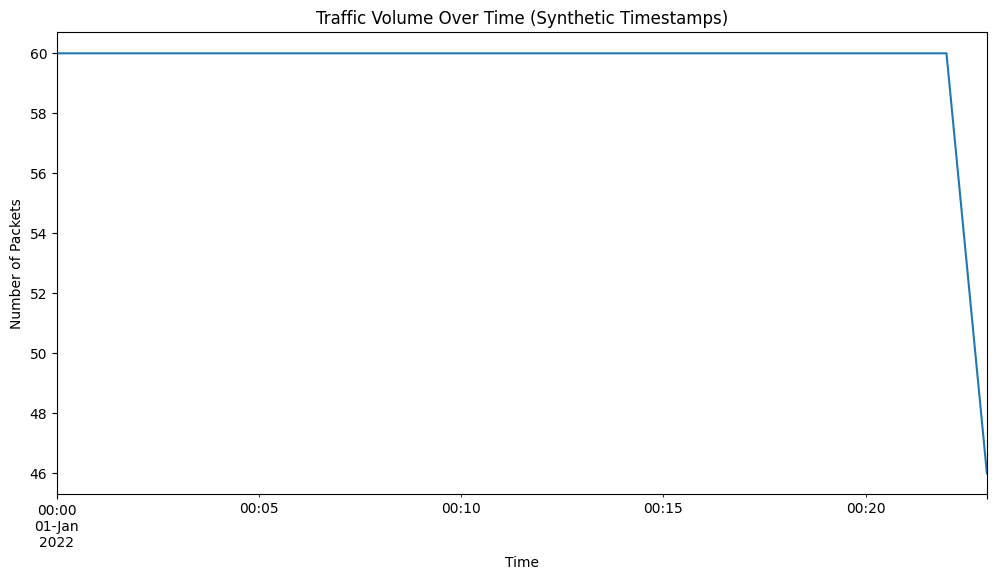

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

# Generate synthetic timestamps (assuming 1-second intervals)
df['frame.time'] = pd.date_range(start='2022-01-01', periods=len(df), freq='S')

# Set synthetic 'frame.time' as the index
df.set_index('frame.time', inplace=True)

# Plot traffic volume over time using synthetic timestamps
df.resample('T').size().plot(figsize=(12, 6))  # Resample by minute
plt.title("Traffic Volume Over Time (Synthetic Timestamps)")
plt.xlabel("Time")
plt.ylabel("Number of Packets")
plt.show()


###  Source and Destination IP Distributions

This shows the most frequent IP addresses for both source and destination, which can help identify key participants in the traffic.

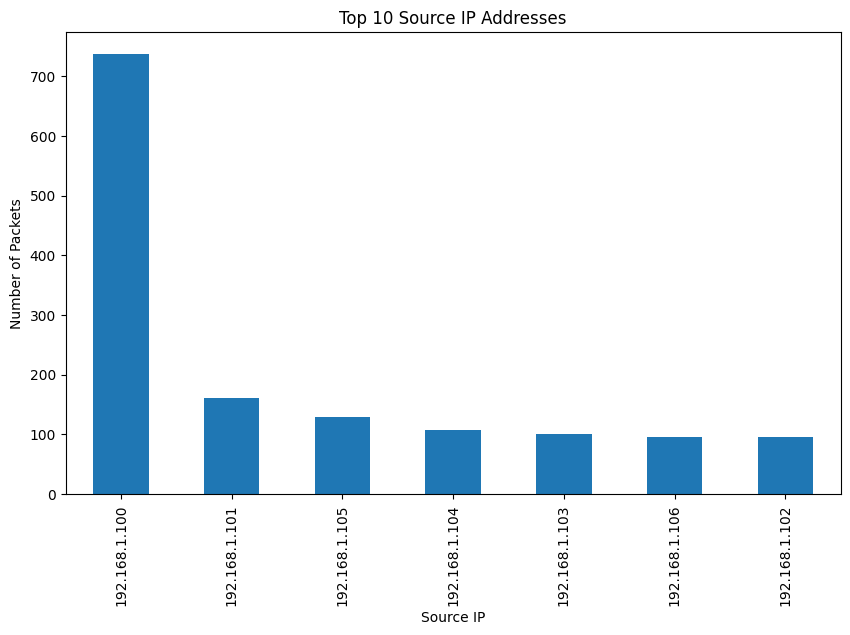

In [57]:
# Plot source IP distribution
plt.figure(figsize=(10, 6))
df['ip.src'].value_counts().nlargest(10).plot(kind='bar')
plt.title("Top 10 Source IP Addresses")
plt.xlabel("Source IP")
plt.ylabel("Number of Packets")
plt.show()

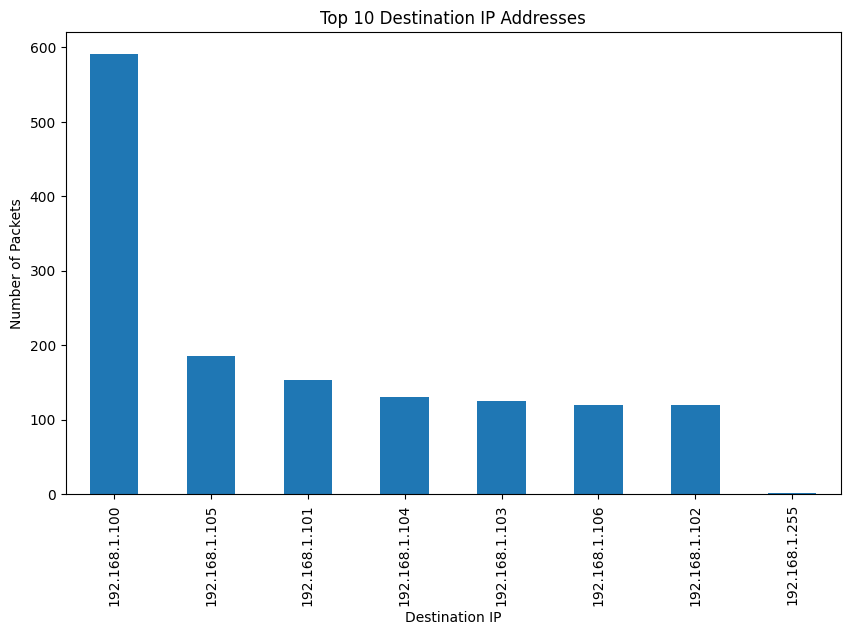

In [58]:
# Plot destination IP distribution
plt.figure(figsize=(10, 6))
df['ip.dst'].value_counts().nlargest(10).plot(kind='bar')
plt.title("Top 10 Destination IP Addresses")
plt.xlabel("Destination IP")
plt.ylabel("Number of Packets")
plt.show()

### Label Distribution

This is useful for understanding the balance between safe and malicious packets.

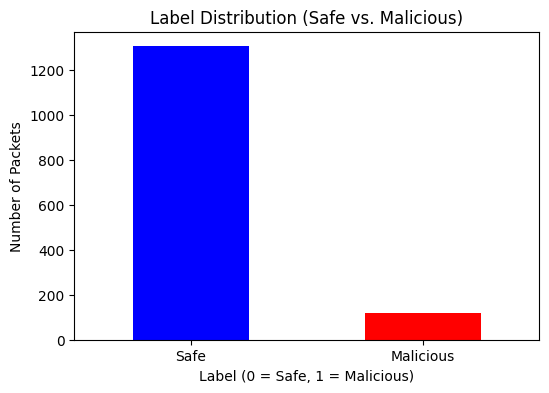

In [59]:
# Plot label distribution (safe vs. malicious)
plt.figure(figsize=(6, 4))
df['label'].value_counts().plot(kind='bar', color=['blue', 'red'])
plt.title("Label Distribution (Safe vs. Malicious)")
plt.xlabel("Label (0 = Safe, 1 = Malicious)")
plt.ylabel("Number of Packets")
plt.xticks([0, 1], labels=["Safe", "Malicious"], rotation=0)
plt.show()

###Correlation Matrix

correlation matrix to check relationships.

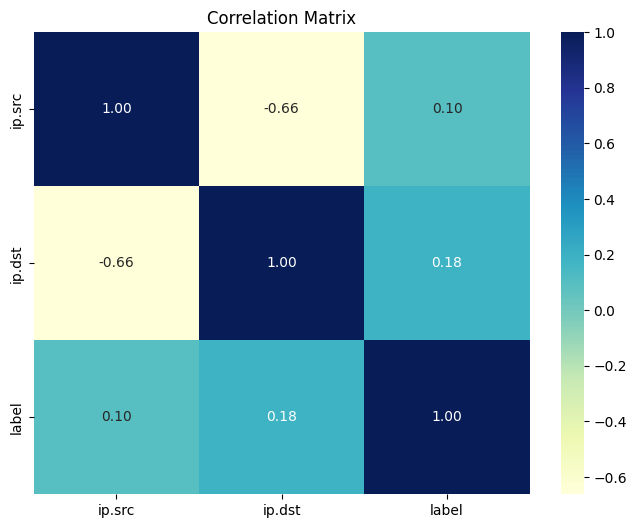

In [60]:
import seaborn as sns
# Convert IP addresses to numeric for correlation matrix
df['ip.src'] = df['ip.src'].astype('category').cat.codes
df['ip.dst'] = df['ip.dst'].astype('category').cat.codes

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


## Data Preprocessing

In [61]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

# One-hot encode the IP addresses
df_encoded = pd.get_dummies(df, columns=['ip.src', 'ip.dst'], drop_first=True)

# Separate features and target
X = df_encoded.drop(columns=['label'])
y = df_encoded['label']

# Handle class imbalance with oversampling
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

# Split the balanced dataset into training and testing sets
# Splitting the dataset into 70% training data and 30% testing data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)


Training set size: (1827, 13)
Test set size: (783, 13)


In [62]:
print("Resampled dataset size:", X_resampled.shape)
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)


Resampled dataset size: (2610, 13)
Training set size: (1827, 13)
Test set size: (783, 13)


## Train a Machine Learning Model

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize the Random Forest model
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9106002554278416
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.92      0.91       391
           1       0.92      0.90      0.91       392

    accuracy                           0.91       783
   macro avg       0.91      0.91      0.91       783
weighted avg       0.91      0.91      0.91       783



In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Initialize the model
clf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Output best parameters and model performance
print("Best Parameters:", grid_search.best_params_)
best_clf = grid_search.best_estimator_

# Evaluate on test set
y_pred = best_clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy: 0.9106002554278416
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.92      0.91       391
           1       0.92      0.90      0.91       392

    accuracy                           0.91       783
   macro avg       0.91      0.91      0.91       783
weighted avg       0.91      0.91      0.91       783



## Model Evaluation with Additional Metrics

In [65]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model with additional metrics
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)

    # Accuracy
    accuracy = accuracy_score(y_test, predictions)
    print(f"Accuracy: {accuracy}")

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, predictions, target_names=["Safe", "Malicious"]))

    # Display the ROC curve to visualize the model's performance in distinguishing between classes
    # ROC Curve and AUC Score
    if len(set(y_test)) == 2:  # Only applicable for binary classification
        auc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc_score:.2f}')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend(loc="lower right")
        plt.show()
    else:
        print("ROC Curve and AUC not applicable for multi-class classification.")


Accuracy: 0.9106002554278416


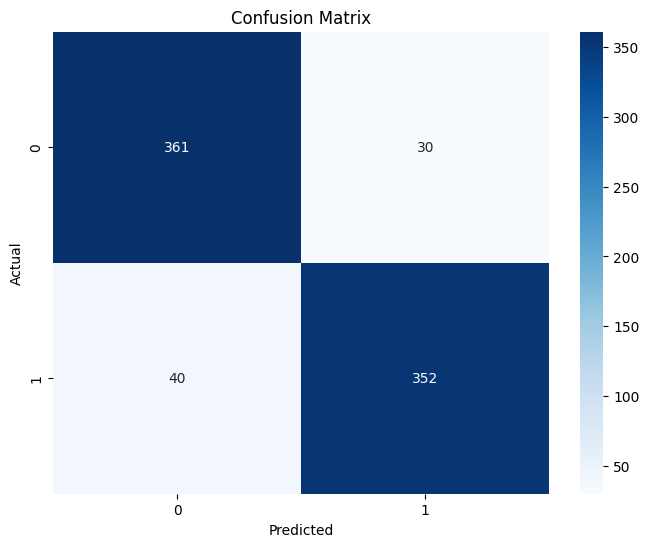

Classification Report:
              precision    recall  f1-score   support

        Safe       0.90      0.92      0.91       391
   Malicious       0.92      0.90      0.91       392

    accuracy                           0.91       783
   macro avg       0.91      0.91      0.91       783
weighted avg       0.91      0.91      0.91       783



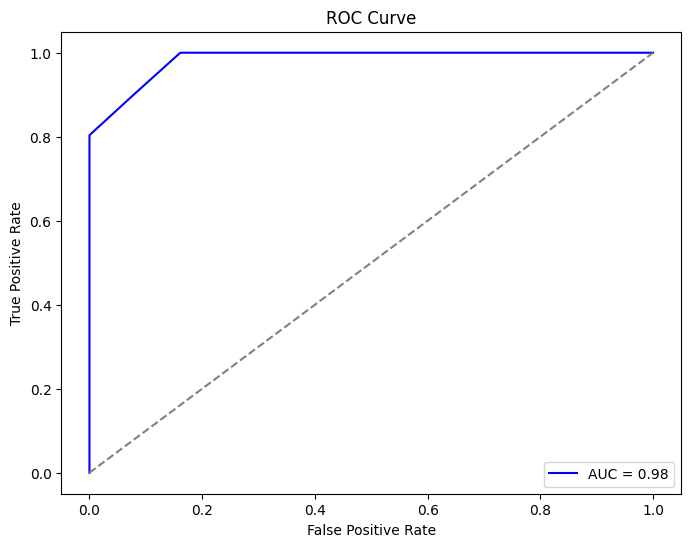

In [66]:
# Train the model
clf = RandomForestClassifier(n_estimators=50, random_state=42)
clf.fit(X_train, y_train)

# Now evaluate the fitted model
evaluate_model(clf, X_test, y_test)


Accuracy: 0.9106002554278416


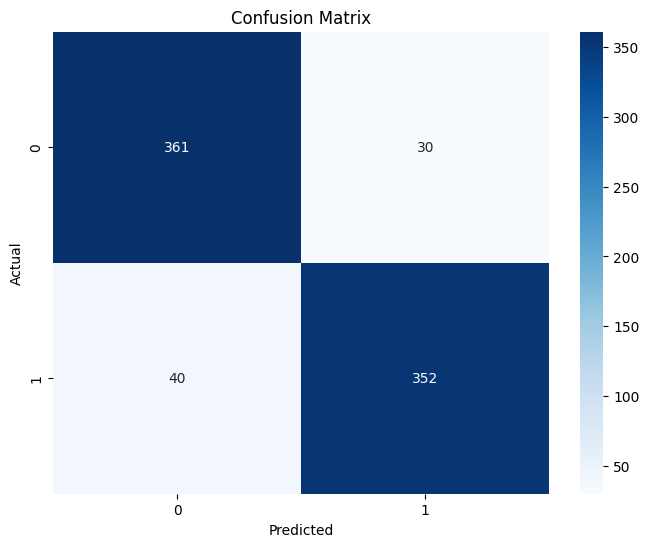

Classification Report:
              precision    recall  f1-score   support

        Safe       0.90      0.92      0.91       391
   Malicious       0.92      0.90      0.91       392

    accuracy                           0.91       783
   macro avg       0.91      0.91      0.91       783
weighted avg       0.91      0.91      0.91       783



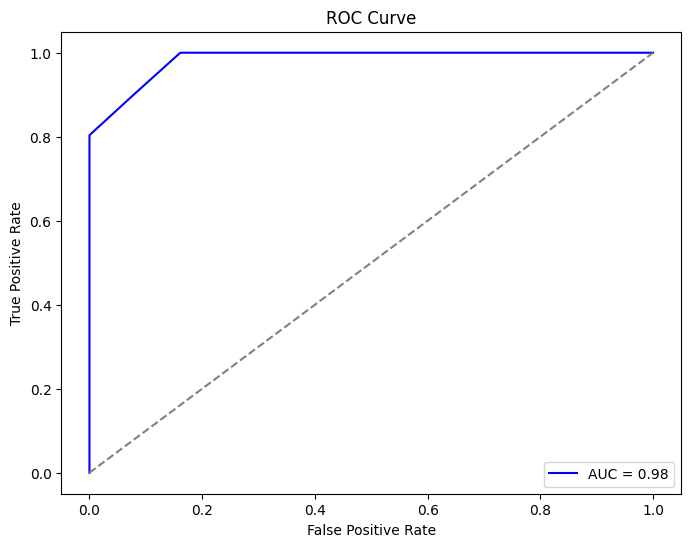

In [67]:
# Assuming X_test and y_test are defined
evaluate_model(clf, X_test, y_test)


## Save the Model for Future Use

Saving the model enables you to load and use it later without retraining. This is particularly useful if you need to integrate it with other systems or explainable AI (e.g., xNIDS).

In [68]:
import joblib

# Save the trained model
joblib.dump(clf, 'modbus_ids_model.pkl')


['modbus_ids_model.pkl']

## Interpret the Model

To understand which features contribute most to the classification, you can check feature importances in the Random Forest model.

In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


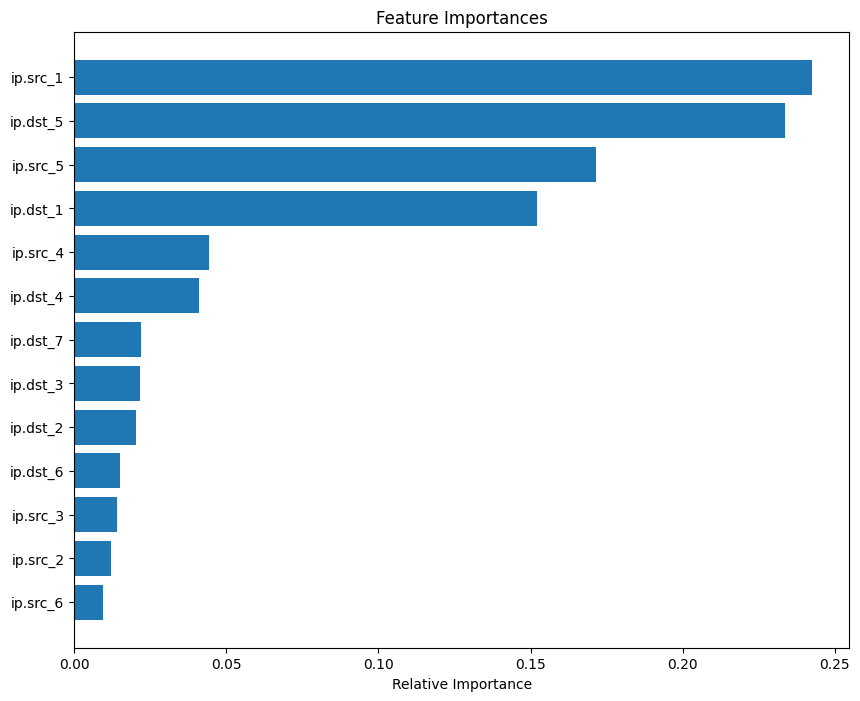

Model saved as modbus_ids_model.pkl in Google Drive.


In [70]:
from sklearn.ensemble import RandomForestClassifier
import joblib
import matplotlib.pyplot as plt

# Assuming X_train and y_train have been defined in your data preprocessing steps

# Initialize and train the model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)  # Make sure to fit the model first

# Access feature importances after the model is fitted
importances = clf.feature_importances_
feature_names = X_train.columns
indices = importances.argsort()

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

# Optionally, save the fitted model for future use
#joblib.dump(clf, 'modbus_ids_model.pkl')
import joblib

# Save the trained model directly to Google Drive
joblib.dump(clf, '/content/drive/MyDrive/Colab Notebooks/xNIDS/modbus_ids_model.pkl')
print("Model saved as modbus_ids_model.pkl in Google Drive.")


In [71]:
# import matplotlib.pyplot as plt

# # Plot feature importances
# importances = clf.feature_importances_
# feature_names = X.columns
# indices = importances.argsort()

# plt.figure(figsize=(10, 8))
# plt.title("Feature Importances")
# plt.barh(range(len(indices)), importances[indices], align='center')
# plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
# plt.xlabel("Relative Importance")
# plt.show()


## Integration with xNIDS Explainer

In [72]:
!git clone https://github.com/CactiLab/code-xNIDS.git
!mv code-xNIDS xNIDS


Cloning into 'code-xNIDS'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 65 (delta 20), reused 9 (delta 4), pack-reused 21 (from 1)
Receiving objects: 100% (65/65), 7.38 MiB | 14.91 MiB/s, done.
Resolving deltas: 100% (25/25), done.


In [73]:
# from google.colab import drive
# drive.mount('/content/drive')


In [74]:
!cp -r xNIDS /content/drive/MyDrive/Colab\ Notebooks/


In [75]:
X_test.to_csv('/content/drive/MyDrive/Colab Notebooks/xNIDS/modbus_data_sample.csv', index=False)
